In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# 예제 8.1 : 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
                             hub.KerasLayer(handle = mobile_net_url, input_shape = (224, 224, 3), trainable = False)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [8]:
# 예제 8.2 : ImageNetV2 - TopImages 불러오기
import os
import pathlib
content_data_url = '/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'http://imagenetv2public.s3-website-us-west-2.amazonaws.com/imagenetv2-topimages.tar.gz', cache_dir = content_data_url, extract = True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

606355456/606351360 [==============================] - 28s 0us/step
/content/sample_data/datasets/imagenetv2-topimages


In [9]:
# 예제 8.3 : 디렉터리 출력
for idx, item in enumerate(data_root.iterdir()):
  print(item)
  if idx == 9:
    break

/content/sample_data/datasets/imagenetv2-topimages/870
/content/sample_data/datasets/imagenetv2-topimages/140
/content/sample_data/datasets/imagenetv2-topimages/524
/content/sample_data/datasets/imagenetv2-topimages/807
/content/sample_data/datasets/imagenetv2-topimages/55
/content/sample_data/datasets/imagenetv2-topimages/971
/content/sample_data/datasets/imagenetv2-topimages/636
/content/sample_data/datasets/imagenetv2-topimages/728
/content/sample_data/datasets/imagenetv2-topimages/693
/content/sample_data/datasets/imagenetv2-topimages/107


In [11]:
# 에제 8.4 : ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None

with open(label_file, 'r') as f:
  label_text = f.read().split('\n')[: -1]

print(len(label_text))
print(label_text[: 10])
print(label_text[-10 :])

16384/10484 [==============================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


image_count : 10000


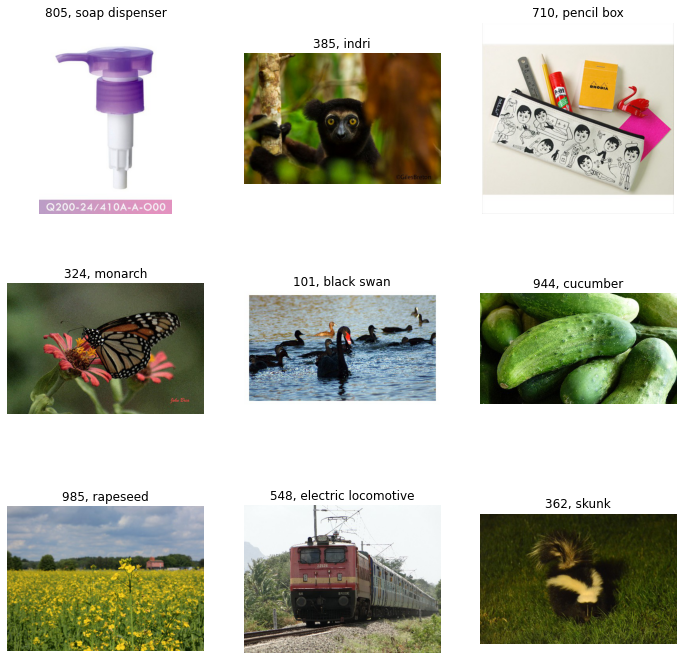

In [13]:
# 예제 8.5 : 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count :', image_count)

plt.figure(figsize = (12, 12))

for c in range(9):
  image_path = random.choice(all_image_paths)
  plt.subplot(3, 3, c + 1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ', ' + label_text[idx])
  plt.axis('off')

plt.show()

In [18]:
# 예제 8.6 : MobileNet의 분류 성능 확인
import cv2
import numpy as np

top_1 = 0
top_5 = 0

for image_path in all_image_paths:
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize = (224, 224))
  img = img / 255.0
  img = np.expand_dims(img, axis = 0)

  # Top-5 정확도를 측정하기 위한 top_5_predict를 구합니다.
  top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
  idx = int(image_path.split('/')[-2]) + 1
  
  if idx in top_5_predict:
    top_5 += 1
    if top_5_predict[0] == idx:
      top_1 += 1

print('Top-5 correctness :', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness :', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness : 83.84 %
Top-1 correctness : 59.45 %


In [20]:
# numpy.argsort()는 값을 정렬하는 대신 인덱스를 정렬합니다.
# argsort() 결과를 다시 원래의 넘파이 array에 넣으면 정렬된 넘파이 array, 즉 sort()를 사용한 것과 같은 결과를 얻게 됩니다.
# 그런데 우리가 원하는 것은 예측 확률이 높은 순서이기 때문에 오름차순으로 정렬된 array를 array[::-1] 로 반전시킵니다.
# 그다음에 앞에서부터 5번째까지의 값을 array[:5] 로 잘라서 top_5_predict에 저장합니다.
a = np.array([99, 32, 5, 64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


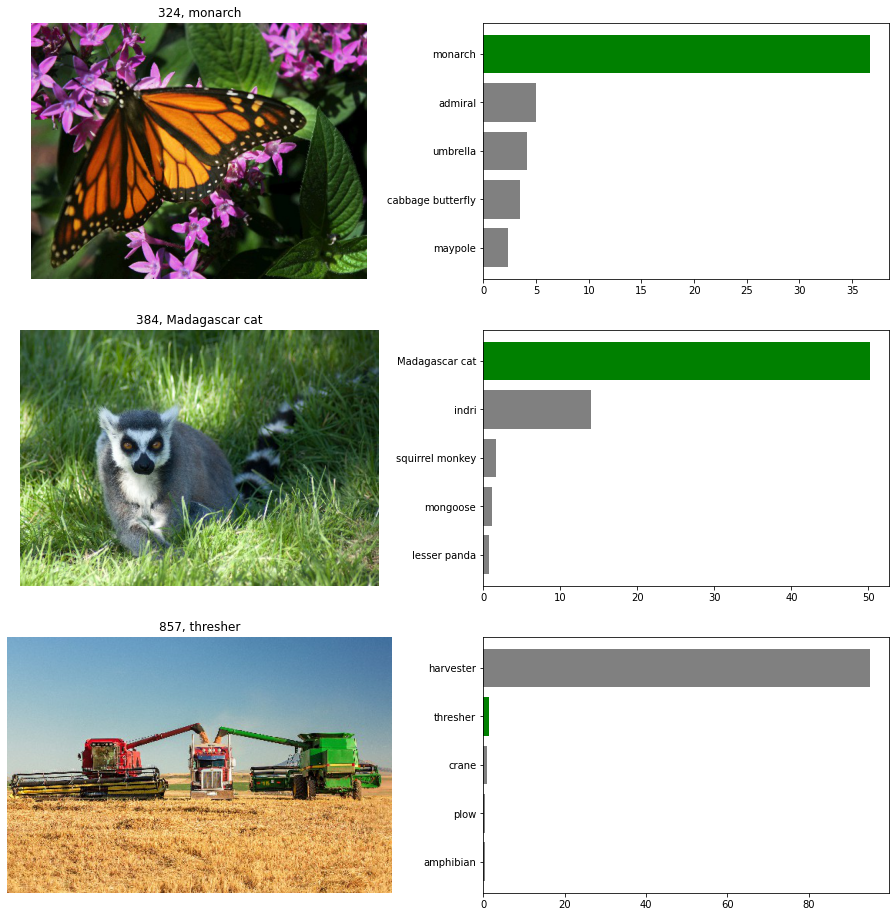

In [35]:
# 예제 8.7 : MobileNet의 분류 라벨 확인
plt.figure(figsize = (16, 16))

def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis = 0)

for c in range(3):
  image_path = random.choice(all_image_paths)

  # 이미지 표시
  plt.subplot(3, 2, c * 2 + 1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ', ' + label_text[idx])
  plt.axis('off')

  # 예측값 표시
  plt.subplot(3, 2, c * 2 + 2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize = (224, 224))
  img = img / 255.0
  img = np.expand_dims(img, axis = 0)

  # MobileNet을 이용한 예측
  logits = model.predict(img)[0]
  prediction = softmax(logits)

  # 가장 높은 확률의 예측값 5개를 뽑음.
  top_5_predict = prediction.argsort()[::-1][:5]
  labels = [label_text[index] for index in top_5_predict]
  color = ['gray'] * 5

  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'

  color = color[:: -1]
  plt.barh(range(5), prediction[top_5_predict][:: - 1] * 100, color = color)
  plt.yticks(range(5), labels[:: -1])